In [77]:
import os
import numpy
import subprocess
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import uproot
import tqdm
import time
%matplotlib inline
import matplotlib as mpl
#mpl.style.use("/Users/pinguino/paper.mplstyle")

In [2]:
# remote mount the GRAMS directory on local machine (requires SSHFS)
host = "ub"
remote_path = "/home/ub/WinDriver/wizard/GRAMS_project_am "
GRAMSdir = os.path.expanduser("~/remote_mount")
os.makedirs(GRAMSdir, exist_ok=True) # make a mount point in your home directory if it doesn't already exist

# mount and unmount commands
mount = f"sshfs {host}:{remote_path} {GRAMSdir} -o kill_on_unmount,reconnect,allow_other,defer_permissions,IdentityFile=~/.ssh/id_rsa"
unmount = f"umount {GRAMSdir}"

try:
    # make sure the directory is not currently mounted, then mount
    subprocess.run(unmount, shell=True, check=True)
    subprocess.run(mount, shell=True, check=True)
except:
    # otherwise just directly mount
    subprocess.run(mount, shell=True, check=True)

In [ ]:
# alternatively, you can set this directory manually:
## GRAMSDir = "/path/to/decoded/root/files"

## Waveform Plotter

In [4]:
# INPUTS/CONFIG

file_list = [1] # list of files you would like plotted
active_ch = 6 # channel number of interest
event_id = 13 # event number
fem_id = 11 # FEM number (usually slot 11 or 12)

overlay = 1 # set to 0 for individual plots, 1 for overlaid plots
#aver

In [21]:
np.asarray(slice_df.index)

array([42570, 42571, 42572, 42573, 42574, 42575, 42576, 42577, 42578,
       42579, 42580, 42581, 42582, 42583, 42584, 42585, 42586, 42587,
       42588, 42589, 42590, 42591, 42592, 42593, 42594, 42595, 42596,
       42597, 42598, 42599, 42600, 42601, 42602, 42603, 42604, 42605,
       42606, 42607, 42608, 42609, 42610, 42611, 42612, 42613, 42614,
       42615, 42616, 42617, 42618, 42619, 42620, 42621, 42622, 42623,
       42624])

In [28]:
df['adc_count']

0         2045
1         2046
2         2045
3         2045
4         2045
          ... 
470744    2044
470745    2049
470746    2049
470747    2049
470748    2049
Name: adc_count, Length: 470749, dtype: int32

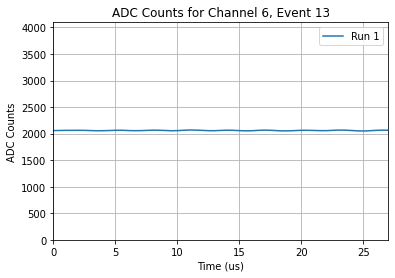

In [30]:
if overlay == 1:
    plt.figure()

for filename in file_list:
    # open file and extract tree into a pandas dataframe
    file = uproot.open(f"{GRAMSdir}/outfile_{filename}bkp.root")
    tree = file["adc_tree"]
    df = tree.arrays(library="np")

    # slice dataframe for desired channel, FEM, and event
    mask = (df['fem_id'] == fem_id) & (df['event_id'] == event_id) & (df['channel_id'] == active_ch)

    # create time axis (2 MHz sampling rate -> 0.5 us steps)
    time = 0.5*(np.asarray(slice_df.index) - np.asarray(slice_df.index.min()))
    
    # plot
    if overlay == 1:
        # if overlay is enabled, plot on the same figure
        plt.plot(time, df['adc_count'][mask], label=f'Run {filename}')
    else:
        # if overlay is disabled, new figure for each run
        plt.figure()
        plt.plot(time, df['adc_count'][mask])
        plt.title(f'ADC Counts for Channel {active_ch}, Event {event_id}, Run {filename}')
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.xlim(time.min(), time.max())
        plt.ylim(0, 4095)
        plt.grid(True)
        plt.show()
    
# show legend if overlay is enabled
if overlay == 1:
    plt.title(f'ADC Counts for Channel {active_ch}, Event {event_id}')
    plt.xlabel('Time (us)')
    plt.ylabel('ADC Counts')
    plt.xlim(time.min(), time.max())
    plt.ylim(0, 4095)
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# average plotter

## Linearity/Dynamic Range

In [31]:
# INPUTS/CONFIG

active_ch = [6, 8, 12, 14, 16, 20, 22, 24] # channel numbers of interest
fem_id = 12 # FEM number (usually slot 11 or 12)
file_id = f"{GRAMSdir}/file_id.csv" # path to .csv with run IDs, run input pulse heights in mV, and ADC ch. no's

overlay = 1 # set to 0 for individual plots, 1 for overlaid plots

### ADC Amplitude vs. Input Charge Plotter

analyzing channel 24: 100%|██████████| 13/13 [00:01<00:00,  8.35it/s]


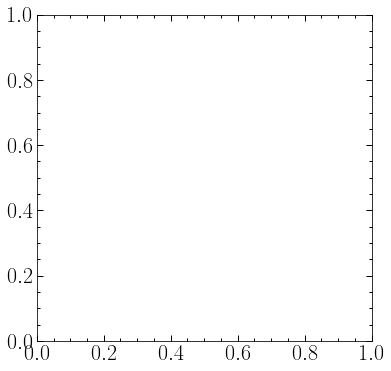

In [58]:
# read file_id into dataframe
csv = pd.read_csv(file_id)

#initialize figure
#if overlay == 1:
#    ampQ, ax = plt.subplots()

Q = dict()
peaks = dict()
for ch in active_ch:
    # extract file_list for given channel
    slice_ch = csv[csv.iloc[:,2].isin([ch])]
    file_list = slice_ch.iloc[:,0].tolist()
    
    # extract pulse heights in mV for this file_list
    slice_mV = csv[csv.iloc[:, 0].isin(file_list)]
    mV = slice_mV.iloc[:, 1].tolist()
    
    # convert to charge
    Vdiv = (1/11) # preamp voltage divider
    Cin = 1 # preamp input capacitance, in pF
    Q[ch] = (np.array(mV) * Vdiv * 10**-3) * (Cin * 10**-12) * 10**15 # charge in fC
    
    peaks[ch] = []
    for filename in tqdm.tqdm(file_list, desc=f'analyzing channel {ch}', total=len(file_list)):
        # open file and extract tree into a pandas dataframe
        file = uproot.open(f"{GRAMSdir}/outfile_{filename}.root")
        tree = file["adc_tree"]
        df = tree.arrays(library="pd")
        
        # slice dataframe for desired FEM and channel, find max height for each event
        slice_df = df[(df['fem_id'] == fem_id) & (df['channel_id'] == ch)]
        grouped = slice_df.groupby('event_id')
        max_counts = grouped['adc_count'].max()
        average_max = peaks[ch].append(max_counts.mean())
    
#     # standard deviation
#     std_dev = np.std(peaks)

In [71]:
def plot_counts_vs_inputQ(Q, peaks, active_ch, overlay=1):
    # if overlay is enabled, plot on the same figure
    if overlay:
        figure = plt.figure(figsize=[9,6])
        [plt.plot(Q[c], peaks[c], marker='x', linestyle='None', label=f'Ch.{c}') for c in active_ch]
        plt.title(f'ADC Amplitude vs. Input Charge')
        plt.xlabel('Input Charge (fC)', fontsize=20)
        plt.ylabel('Counts')
        plt.ylim(plt.ylim()[0], 4150)
        plt.grid(True)
        plt.legend(fontsize=22)
        plt.show()
    else:
        for c in active_ch:
            plt.figure(figsize=[9,6])
            plt.plot(Q[c], peaks[c], marker='x', linestyle='None', label=f'Ch.{c}')
            plt.title(f'ADC Amplitude vs. Input Charge')
            plt.xlabel('Input Charge (fC)', fontsize=20)
            plt.ylabel('Counts')
            plt.ylim(plt.ylim()[0], 4150)
            plt.grid(True)
            plt.legend(fontsize=22)
            plt.show()
            
    return figure

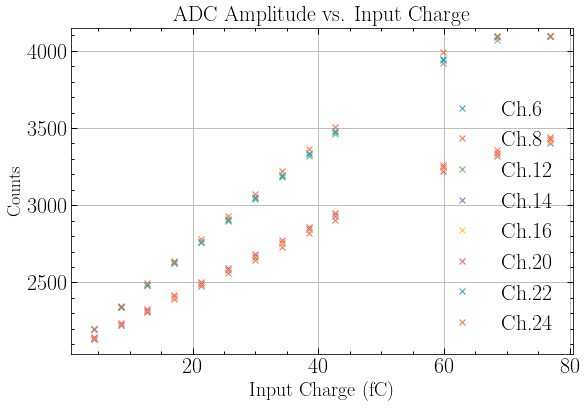

In [79]:
my_figure = plot_counts_vs_inputQ(Q, peaks, active_ch, overlay=1)

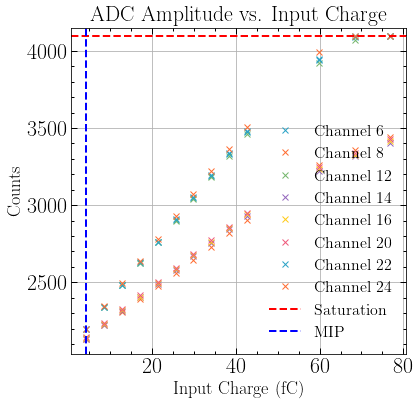

In [49]:
# add noise, saturation, and MIP bound to plot (only if they don't already exist)
if not any(line.get_label() == 'Saturation' for line in ax.get_lines()):
    ax.axhline(y=4095, color='r', linestyle='--', label='Saturation')
if not any(line.get_label() == 'MIP' for line in ax.get_lines()):
    ax.axvline(x=4.27, color='b', linestyle='--', label='MIP')
# if not any(line.get_label() == 'Noise' for line in ax.get_lines()):
#     ax.axhline(y=4095, color='r', linestyle='--', label='Noise')

ax.legend()
ampQ

### Linearity